# event - display with hits and vertex-hits of my_track objects
from 2TracksClusters file (TwoTracksTree)

In [1]:
import sys; sys.path.insert(0, '../');
from ccqe_notebook_tools import *
from tracking_tools import *
%matplotlib inline
# %matplotlib notebook
from IPython.core.display import HTML,display
display(HTML("<style>.container { width:100% !important; }</style>"))
# sys.stdout = open('/dev/stdout', 'w')

In [3]:
File = ROOT.TFile("/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/TracksAnaFiles/Events_MCC8_MC_BNB_extBNB_Pairs.root")
tree = File.Get("pairsTree")
using_genie = False
# File = ROOT.TFile("/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/TracksAnaFiles/Events_MCC8_MC_BNB_extBNB_GENIE2TracksClusters.root")
# tree = File.Get("GENIETwoTracksTree")
# using_genie = True
events = AnalyzeVertex( tree )

In [4]:
#---------------------------------------------------------------------------------------------
def plot_pandoraNuTrack(track,plane,MCmode,ax,do_add_label=True,label_addition=''):
    color, label = set_color_label(track,MCmode=MCmode)
    t_start_wire , t_start_time , t_end_wire , t_end_time = get_t_start_end(track,plane)
    
    if do_add_label: label=label_addition+' track %d '%track.track_id+label 
    else: label=None
    ax.plot( [t_start_wire,t_end_wire] , [t_start_time,t_end_time] ,label=label, color=color,alpha=0.5)
    return t_start_wire , t_start_time , t_end_wire , t_end_time , color
#---------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------
def plot_hits(hits,plane,ax=None,box=None,s=50,cmap='hot_r',marker='o',color='',do_add_numbers=False):
    if box is None: box = [ -1 , 10000 , -1 , 10000 ]
    hit_wire, hit_time, hit_charge , hit_number  = [] , [] , [] , []
    # hits in this plane
    for i_hit,hit in enumerate(hits):
        if hit.hit_plane==plane and hit_in_box(hit,box=box):
            hit_number.append(i_hit)
            hit_wire.append(hit.hit_wire)
            hit_time.append(hit.hit_peakT)
            hit_charge.append(hit.hit_charge)
    if ax is not None and hit_wire is not None and hit_time is not None and hit_charge is not None and len(hit_wire)>0:
        if color == '':
            ax.scatter(hit_wire,hit_time,marker=marker,s=s,c=hit_charge, vmin=np.min(hit_charge), vmax=np.max(hit_charge),cmap='hot_r')
        else:
            ax.scatter(hit_wire,hit_time,c=color,marker=marker,s=s)
    if do_add_numbers:
        for w,t,n in zip(hit_wire , hit_time, hit_number): ax.text( w , t , n )

    return hit_wire, hit_time, hit_charge , hit_number
#---------------------------------------------------------------------------------------------




#---------------------------------------------------------------------------------------------
def plot_vertex(all_hits=None , tracks=None, vertex=None , closeup=None,
                planes=[0,1,2], MCmode=True , figsize=(16,6),
                do_add_numbers=False , debug=0 , ax=None , fontsize=20,
                do_possible_hits=False,
                do_save_image=False, dw=30, dt=100):
    
    if debug>1: print vertex.run,vertex.subrun,vertex.event
        
    fig = plt.figure(figsize=(16,6))
    for plane in planes:        

        non_associated_hits = []
        if debug: print 'plane',plane
        title = "%d/%d/%d (v-%d) "%(vertex.run,vertex.subrun,vertex.event,vertex.vertex_id) + '%s plane'%('u' if plane==0 else 'v' if plane==1 else 'y') 
        ax = fig.add_subplot(1,3,plane+1); ax.set_title(title,y=1.02)
        
        roi = vertex.roi_u if plane==0 else vertex.roi_v if plane==1 else vertex.roi_y
        min_wire , max_wire , min_time , max_time = roi.start_wire , roi.end_wire , roi.start_time , roi.end_time

        AllHitsInROI = vertex.AllHitsInROI_u if plane==0 else vertex.AllHitsInROI_v if plane==1 else vertex.AllHitsInROI_y
        non_associated_hits = [hit for hit in AllHitsInROI]
        # hits
        hit_wire, hit_time, hit_charge , hit_number = plot_hits(hits=all_hits,plane=plane,ax=ax)

        # pandoraNu tracks
        for track in [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]:
            t_start_wire , t_start_time , t_end_wire , t_end_time , color = plot_pandoraNuTrack(track=track,plane=plane,MCmode=MCmode,ax=ax)
            # TRACKs boxes
            if debug>1: ax.add_patch( patches.Rectangle( (t_start_wire, t_start_time),                    
                                                        (t_end_wire-t_start_wire) , (t_end_time-t_start_time) ,                                             
                                                        color=color , alpha=0.6,fill=False) )                        
        for track in tracks:
            if track.track_id != vertex.AssignedMuonTrack.track_id and track.track_id !=  vertex.AssignedProtonTrack.track_id:
#                 t_start_wire , t_start_time , t_end_wire , t_end_time = get_t_start_end(track,plane)
#                 if (min_wire < t_start_wire and t_start_wire < max_wire) or (min_wire < t_end_wire and t_end_wire < max_wire) or (min_time < t_start_time and t_start_time < max_time) or (min_time < t_end_time and t_end_time < max_time):
                plot_pandoraNuTrack(track=track,plane=plane,MCmode=MCmode,ax=ax,do_add_label=False,label_addition='(external)')
            
        my_track_muon = vertex.MyTrackMuon_u if plane==0 else vertex.MyTrackMuon_v if plane==1 else vertex.MyTrackMuon_y
        my_track_proton = vertex.MyTrackProton_u if plane==0 else vertex.MyTrackProton_v if plane==1 else vertex.MyTrackProton_y
    
        # my-tracks
        total_charge_in_my_tracks = 0
#         for my_track in [my_track_muon,my_track_proton]:
#             color, label = set_color_label(my_track.pandoraNu_track,MCmode=MCmode)
#             associated_hits = [hit for hit in my_track.hits]
#             for hit in associated_hits:
#                 if hit in non_associated_hits:
#                     non_associated_hits.remove(hit)
            
#             if debug>1:
#                 if len(associated_hits)>0: 
#                     print 'hits in my-track',my_track.pandoraNu_track.track_id
#                     for hit in associated_hits:
#                         print [hit.hit_wire, hit.hit_peakT]
#                 else: print 'no hits in my-track',my_track.pandoraNu_track.track_id


#             if do_possible_hits: plot_hits(hits=my_track.possible_hits,plane=plane,ax=ax,marker='s',s=3,color=color)                
                    
#             my_track_hits = [hit for hit in my_track.hits]            
#             hit_wire, hit_time, hit_charge , hit_number = plot_hits(hits=my_track.hits,plane=plane
#                                                                     ,ax=ax,color=color
#                                                                     ,do_add_numbers=do_add_numbers)
#             total_charge_in_my_tracks += np.sum(hit_charge)


        # CC1p ROI
        ax.add_patch( patches.Rectangle( (min_wire , min_time ),(max_wire - min_wire) , (max_time - min_time) ,fill=False) )
        # vertex position
        ax.scatter( vertex.vertex_wire[plane], vertex.vertex_time[plane] , c='green', s=100 , alpha=0.3)
        if debug: print 'vertex position:',vertex.vertex_wire[plane], vertex.vertex_time[plane]
        # truth vertex position
        genie_interaction = vertex.genie_interaction
        pos_wire = genie_interaction.pos_wire_u if plane==0 else genie_interaction.pos_wire_v if plane==1 else genie_interaction.pos_wire_y
        pos_time = genie_interaction.pos_time_u if plane==0 else genie_interaction.pos_time_v if plane==1 else genie_interaction.pos_time_y
        if debug: print 'truth vertex position:',pos_wire, pos_time
        ax.scatter( pos_wire, pos_time , c='purple', s=100 , alpha=0.3)


        # charge deposition
        if debug: print 'plane',plane,',total charge in roi:',vertex.AllChargeInVertexROI[plane],'ADC',',total charge in tracks',total_charge_in_my_tracks,'ADC'
        ratio_charge = vertex.ratio_associated_hit_charge_to_total[plane]
        if debug: print ratio_charge,'of the charge is in my tracks'

        ax.set_xlim( min_wire - dw , max_wire + dw )
        ax.set_ylim( min_time - dt , max_time + dt )
        if closeup is not None:
            ax.set_xlim( closeup[0] , closeup[2] )
            ax.set_ylim( closeup[1] , closeup[3] )            
        ax.xaxis.set_major_locator(LinearLocator(4));ax.yaxis.set_major_locator(LinearLocator(4))
        set_axes(ax,x_label='wire',y_label='peak-time' if plane==0 else '',fontsize=fontsize)
        ax.grid(linestyle='--',alpha=0.5,which='both')
#         if plane==0: plt.text( min_wire + 5 , min_time + 5 , "%d/%d/%d (%d)"%(vertex.run,vertex.subrun,vertex.event,vertex.vertex_id))
        if plane!=0 and debug<2: ax.yaxis.set_major_formatter( NullFormatter() )
        if MCmode and plane==0: ax.legend(loc='best',fontsize=fontsize)
            
        if debug:
            if len(non_associated_hits)>0: 
                print 'non-associated hits in roi'
                for hit in non_associated_hits:
                    print [hit.hit_wire, hit.hit_peakT, hit.hit_charge]
            else:
                print 'all hits in roi are track-associated'
    if debug: print 'average ratio of associated hit charge to total:',vertex.average_ratio_associated_hit_charge_to_total
    plt.tight_layout()
    if do_save_image:
        plt.tight_layout()
        fig.savefig('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/ClassificationOfCC1p/Figures/r%d_s%d_e%d_vertex%d.pdf'%(vertex.run,vertex.subrun,vertex.event,vertex.vertex_id))
#---------------------------------------------------------------------------------------------



#---------------------------------------------------------------------------------------------
def print_vertex_info( vertex=None ):
    print 'vertex',vertex.vertex_id
    if using_genie:
#     if vertex.GENIECC1p:         
        print 'vertex',vertex.position.x(),vertex.position.y(),vertex.position.z()
        print 'genie vertex at',vertex.genie_interaction.vertex_position.x(),vertex.genie_interaction.vertex_position.y(),vertex.genie_interaction.vertex_position.z()
        print 'IsVertexReconstructed: ',vertex.IsVertexReconstructed

        print 'Np,Nπ,Nn:',vertex.genie_interaction.Np,vertex.genie_interaction.Npi,vertex.genie_interaction.Nn
#         print 'start position u-plane:',vertex.muonTrueTrack.start_wire_u,vertex.muonTrueTrack.start_time_u,vertex.muonTrueTrack.end_wire_u,vertex.muonTrueTrack.end_time_u
        print 'truth thata_pq',vertex.genie_interaction.theta_pq,'reconstructed theta_pq',vertex.reco_CC1p_theta_pq
        truth_Ev = vertex.genie_interaction.nu.E()
        truth_Pmu = vertex.genie_interaction.muon.P()
        truth_Pp = vertex.genie_interaction.protons[0].P() if vertex.genie_interaction.Np>0 else -100
        
    else: 
        closest_genie = vertex.closest_genie_interaction
        if (vertex.position-closest_genie.vertex_position).Mag() > 30:
            print 'no genie closer than 30 cm'
            return 
        print 'closest genie vertex (%.1f cm)'%(vertex.position-closest_genie.vertex_position).Mag(),'Np,Nπ,Nn:',closest_genie.Np,closest_genie.Npi,closest_genie.Nn        
        truth_Ev = closest_genie.nu.E()
        truth_Pmu = closest_genie.muon.P()
        truth_Pp = closest_genie.protons[0].P() if closest_genie.Np>0 else -100
        print 'truth thata_pq',closest_genie.theta_pq,'reconstructed theta_pq',vertex.reco_CC1p_theta_pq
    
    muon_track = vertex.AssignedMuonTrack
#     muon_track = vertex.LongestTrack
    print 'assigned-µ, track %d'%vertex.AssignedMuonTrack.track_id
    print 'true momentum: ',truth_Pmu,'reconstructed:',vertex.reco_CC1p_Pmu_3momentum
    print 'true l: ',(muon_track.truth_end_pos-muon_track.truth_start_pos).Mag(),'reconstructed:',(muon_track.end_pos-muon_track.start_pos).Mag()

    print 'true start: %1.f,%.1f,%.1f'%(muon_track.truth_start_pos.x(),muon_track.truth_start_pos.y(),muon_track.truth_start_pos.z())
    print 'start: %.1f,%.1f,%.1f'%(muon_track.startx,muon_track.starty,muon_track.startz)
    print 'true end: %.1f,%.1f,%.1f'%(muon_track.truth_end_pos.x(),muon_track.truth_end_pos.y(),muon_track.truth_end_pos.z())
    print 'end: %.1f,%.1f,%.1f'%(muon_track.endx,muon_track.endy,muon_track.endz)

    proton_track = vertex.AssignedProtonTrack
    print 'assigned-p, track %d'%vertex.AssignedProtonTrack.track_id
    print 'true momentum: ',truth_Pp,'reconstructed:',vertex.reco_CC1p_Pp_3momentum
    print 'true l: ',(proton_track.truth_end_pos-proton_track.truth_start_pos).Mag(),'reconstructed:',(proton_track.end_pos-proton_track.start_pos).Mag()

    print 'truth start: %.1f,%.1f,%.1f'%(proton_track.truth_start_pos.x(),proton_track.truth_start_pos.y(),proton_track.truth_start_pos.z())
    print 'start :%.1f,%.1f,%.1f'%(proton_track.startx,proton_track.starty,proton_track.startz)
    print 'truth end: %.1f,%.1f,%.1f'%(proton_track.truth_end_pos.x(),proton_track.truth_end_pos.y(),proton_track.truth_end_pos.z())
    print 'end: %.1f,%.1f,%.1f'%(proton_track.endx,proton_track.endy,proton_track.endz)
    
    print 'truth Ev: ',truth_Ev,'reco Ev:',vertex.reco_CC1p_Pnu.E()


    print '------------------'
#---------------------------------------------------------------------------------------------

vertex 6
vertex 56.8776493073 62.184419632 995.787719727
genie vertex at 55.8455238342 62.6498527527 997.194030762
IsVertexReconstructed:  1
Np,Nπ,Nn: 1 0 0
truth thata_pq 4.37877035141 reconstructed theta_pq 27.1547489166
assigned-µ, track 4
true momentum:  0.722755863485 reconstructed: 0.240190163255
true l:  410.586775878 reconstructed: 55.9211995171
true start: 56,62.6,997.2
start: 57.6,62.8,996.0
true end: -131.7,-182.5,1268.0
end: 30.7,35.3,1036.6
assigned-p, track 3
true momentum:  0.976344532601 reconstructed: 0.829923570156
true l:  57.6347501635 reconstructed: 55.2148394675
truth start: 55.8,62.6,997.2
start :56.2,61.6,995.6
truth end: 78.3,94.8,1039.4
end: 77.6,92.8,1035.8
truth Ev:  1.18505984078 reco Ev: 0.80849391222
------------------


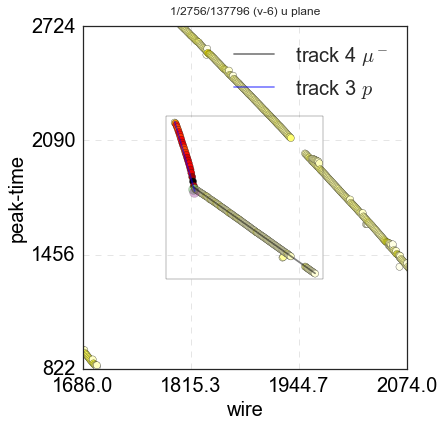

In [21]:
# when taking vertex number from ReportMCBNBextBNB notebook, subtract indices since multiple vertices go into the same event
i=6 # true CC1p: i=26 / 1mu1p non CC1p: i=24 / i=25 vertex 1
hits, tracks, TwoTracksClusters = get_CC1p_tracks( events=events, i=i )
if TwoTracksClusters['Nclusters']==0: print 'no vertices in entry',i
for j in range(TwoTracksClusters['Nclusters']):
    vertex = TwoTracksClusters['vertex %d'%j]    
    print_vertex_info ( vertex=vertex )
    plot_vertex( all_hits=hits , tracks=tracks , vertex=vertex , figsize=(16,6) , MCmode=True 
                , planes=[0] 
                , debug=0 
                , do_add_numbers=False
                , do_possible_hits=False
                , do_save_image=False
                , dw=100, dt=500              
               )